Read the input csvs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

##Data Preparation

LabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and 
n_classes-1.

In [2]:
def encode(train, test):
    le = LabelEncoder().fit(train.species) 
    labels = le.transform(train.species)           # encode species strings
    classes = list(le.classes_)                    # save column names for submission
    test_ids = test.id                             # save test ids for submission
    
    train = train.drop(['species', 'id'], axis=1)  
    test = test.drop(['id'], axis=1)
    
    return train, labels, test, test_ids, classes

train, labels, test, test_ids, classes = encode(train, test)
train.head(1)

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.0,0.00293,0.00293,0.035156,0.0,0.0,0.004883,0.0,0.025391


##Stratified Train/Test Split

*Stratification* is necessary for this dataset because there is a relatively large number of classes (100 classes 
for 990 samples). This will ensure we have all classes represented in both the train and test indices.

StratifiedShuffleSplit returns stratified randomized folds. The folds are made by preserving the percentage of 
samples for each class.

In [3]:
sss = StratifiedShuffleSplit(labels, 10, test_size=0.2, random_state=23)

for train_index, test_index in sss:
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


##Sklearn Classifier Showdown

Simply looping through 10 out-of-the box classifiers and printing the results. Obviously, these will perform much 
better after tuning their hyperparameters, but this gives you a decent ballpark idea.

In [4]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LogisticRegression(solver='lbfgs', multi_class='multinomial')]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 88.8889%
Log Loss: 1.57550751299
SVC
****Results****
Accuracy: 81.8182%
Log Loss: 4.60016294989
DecisionTreeClassifier
****Results****
Accuracy: 68.1818%
Log Loss: 10.9896106711
RandomForestClassifier
****Results****
Accuracy: 88.3838%
Log Loss: 1.30243081663
AdaBoostClassifier
****Results****
Accuracy: 4.5455%
Log Loss: 4.20721577649
GradientBoostingClassifier
****Results****
Accuracy: 52.5253%
Log Loss: 2.64126410491
GaussianNB
****Results****
Accuracy: 57.0707%
Log Loss: 14.8272524928
LogisticRegression
****Results****
Accuracy: 59.0909%
Log Loss: 4.17321638628


##Visualization

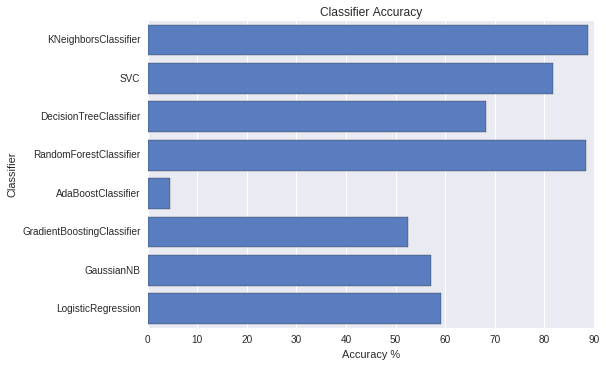

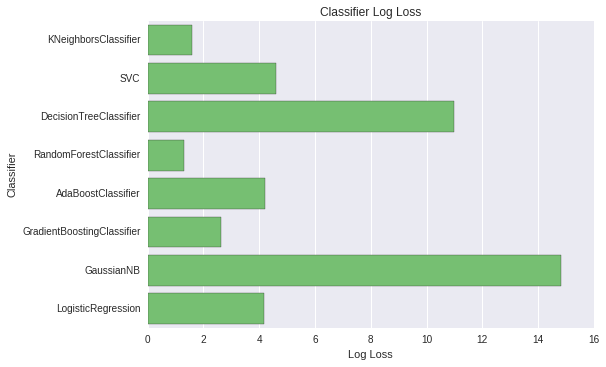

In [5]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()